In [5]:

# imports
from scipy.optimize import curve_fit
import numpy
import pandas
import datetime
from matplotlib import pyplot, figure

In [7]:
""" 
configuration
"""

fleet_sizes = {
    1:[1,2],
    2:[3,9],
    3:[10,99],
    4:[100,999]   
}

In [8]:
""" 
data loading
"""


# load data files and set columns names

events = pandas.read_csv("/ServersExercise/Data/connectivity_events.csv")
events.columns = ['date','device_id','user_id','server_id','connection_state']

servers = pandas.read_csv("/ServersExercise/Data/servers.csv")
servers.columns = ['id','created_at','destroyed_at']



In [9]:
""" 
select first day from data

no need to run this!

not necessary, for whole program
kept here to be able to test app improvements on one day only.
"""

# events date to datetype
events['date'] = pandas.to_datetime(events['date'])

# create column with date only
events['date_only'] = events['date'].dt.date

# get first day date beggining and end
current_day = events.loc[0]['date_only']
next_day = current_day + datetime.timedelta(days=1)

# create one day mask - set True to events that are in selected timeframe
one_day_mask = (events['date_only'] >= current_day) & (events['date_only'] < next_day)

# select first day
one_day_events = events.loc[one_day_mask]


In [10]:
""" 
get data frame only with devices first connection
"""

# return list of devices first connection only
def get_first_connections(events_list):
    # list devices
    one_day_devices = events_list['device_id']
    
    # get dictionary of first device connection
    only_first_device_connection_dict = one_day_devices.drop_duplicates()
    
    # deictionary - data frame 
    only_first_device_connection = pandas.DataFrame(list(only_first_device_connection_dict.items()), columns = ['original_id','device'])
    return only_first_device_connection


In [128]:
"""
get data frame with events with devices first connection of 
"""

# return list of events with first connection only
def only_first_con_events(events_list):
    # get devices dictionary
    first_con_device_dict = get_first_connections(events_list)
    # build first connection events id's list
    first_con_ids = first_con_device_dict['original_id'].values.tolist()
    return events.iloc[first_con_ids]



In [12]:
"""
calculate number of devices for every user
"""

# calculate number of devices used by every user
def calculate_users_devices(events_list):
    # first device connection data set
    first_connections = only_first_con_events(events_list)
    # user:number of devices
    temp_dict = {}
    # build dictionary
    first_connections.apply(add_user_device, 'columns',  users_dict=temp_dict)
    return temp_dict
    


# fucntion used in apply to sum up number of users devices
def add_user_device(row, users_dict):
    user_index = row[2]
    device_index = row[1]
    if user_index in users_dict:
        users_dict[user_index] += 1
    else:
        users_dict[user_index] = 1

     

In [13]:
"""
match results with fleet sizes
"""

# set users to fleet sizes
def check_users_fleet_sizes(events_list):
    devices_dict = calculate_users_devices(events_list)
    # dictionary to df
    devices = pandas.DataFrame.from_dict(devices_dict, orient='index')
    # init dictonary with fleets sizes
    numbers_of_fleets = {
        1:0,
        2:0,
        3:0,
        4:0  
    } 

    
    devices.apply(assign_to_fleet_size, 'columns', fleets_dict=numbers_of_fleets)
    return numbers_of_fleets
    
    
# function used in apply to assign user to matching fleet size
def assign_to_fleet_size(row, fleets_dict):
    number_of_devices = row[0]
    for key in fleet_sizes:
        if check_fleet_size(number_of_devices,fleet_sizes[key]):
            fleets_dict[key] += 1
            break
            
    
# returns bolean if specified number of devices matches selected fleet size
def check_fleet_size(number_of_devices, fleet_description):
    return fleet_description[0] <= number_of_devices <= fleet_description[1]


In [14]:
"""
find number of days
"""
# first and last event date
first_day = events['date'][events.index[0]]
last_day = events['date'][events.index[-1]]
# convert those dates to datetime
first_day_datetime = pandas.to_datetime(first_day)
last_day_datetime = pandas.to_datetime(last_day)
# find timedelta
events_timedelta = last_day_datetime - first_day_datetime
# find number of days
number_of_days = events_timedelta.days


In [12]:
"""
iterate through all days to gather the data
"""

# events date to datetype
events['date'] = pandas.to_datetime(events['date'])
# create column with date only
events['date_only'] = events['date'].dt.date
# get first day
current_day = events.loc[0]['date_only']

all_days_list = []
# iterate through all days
for day in range(number_of_days):
    # get current day end
    next_day = current_day + datetime.timedelta(days=1)
    # create one day mask - set True to events that are in selected timeframe
    one_day_mask = (events['date_only'] >= current_day) & (events['date_only'] < next_day)
    # select first day
    one_day_events = events.loc[one_day_mask]
    # get fleet sizes
    fleet_size = check_users_fleet_sizes(one_day_events)
    
    all_days_list.append(fleet_size)
    current_day = next_day
    

# !!! ToDo
# matplotlib - list of dictionaries
    
    
    

In [153]:
"""
iterate through X days to gather the data
"""

X = 200

# events date to datetype
events['date'] = pandas.to_datetime(events['date'])
# create column with date only
events['date_only'] = events['date'].dt.date
# get first day
current_day = events.loc[0]['date_only']

all_days_list = []
# iterate through all days
for day in range(X):
    # get current day end
    next_day = current_day + datetime.timedelta(days=1)
    # create one day mask - set True to events that are in selected timeframe
    one_day_mask = (events['date_only'] >= current_day) & (events['date_only'] < next_day)
    # select first day
    one_day_events = events.loc[one_day_mask]
    # get fleet sizes
    fleet_size = check_users_fleet_sizes(one_day_events)
    
    all_days_list.append(fleet_size)
    current_day = next_day
    

    

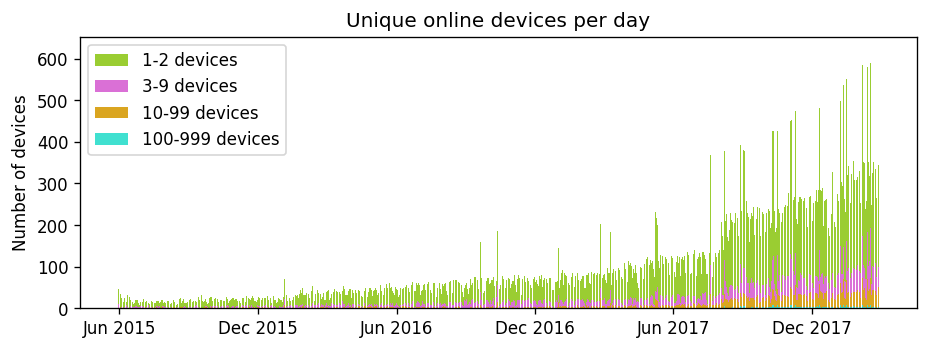

In [13]:
"""
draw bar plot
"""
# parameters
ticks_divider = 6  # x label tick every N months
graph_width = 9
graph_height = 3
graph_dpi = 120


# generate labels list
labels = []
for element in fleet_sizes:
    labels.append("{}-{} devices".format(fleet_sizes[element][0], fleet_sizes[element][1]))
    
# build groups lists
group1 = []
group2 = []
group3 = []
group4 = []
x = []
for ndx, day in enumerate(all_days_list):
    group1.append(day[1])
    group2.append(day[2])
    group3.append(day[3]) 
    group4.append(day[4])
    x.append(ndx)
    
# X label ticks    
# first and last date
first_day = events.loc[0]['date']
last_day = first_day + datetime.timedelta(days=len(all_days_list))
# generate list of months for x label
start_month_days = pandas.date_range(first_day, last_day, freq='MS')
x_label_ticks = start_month_days.strftime('%b %Y').tolist()
# calculate ticks locations
x_ticks_locations = []
for day in start_month_days:
    delta = day-first_day
    x_ticks_locations.append(delta.days)

# plot configuration

pyplot.figure(num=None, figsize=(graph_width,graph_height), dpi=graph_dpi)
pyplot.xticks(x_ticks_locations[0::ticks_divider], x_label_ticks[0::ticks_divider])
pyplot.ylabel('Number of devices')
pyplot.title('Unique online devices per day')

# bar plots
plot1 = pyplot.bar(x, group1, color='yellowgreen', label = labels[0])
plot2 =  pyplot.bar(x, group2, color='orchid', label = labels[1])
plot3 = pyplot.bar(x, group3, color='goldenrod', label = labels[2])
plot4 =  pyplot.bar(x, group4, color = 'turquoise', label = labels[3])

pyplot.legend()
pyplot.show()
    


In [14]:
"""
TASK 2

calculate users number of devices
"""

# set users to fleet sizes
def check_users_number_of_devices(events_list):
    devices_dict = calculate_users_devices(events_list)
    # dictionary to data frame
    devices = pandas.DataFrame.from_dict(devices_dict, orient='index')
    # calculate number of devices
    number_of_devices = devices.sum(axis=0)
    return number_of_devices.values[0]



In [15]:
"""
TASK 2 

iterate through X days to calculate number of devices for each day
"""

X = 200

# events date to datetype
events['date'] = pandas.to_datetime(events['date'])
# create column with date only
events['date_only'] = events['date'].dt.date
# get first day
current_day = events.loc[0]['date_only']

all_days_list = []
# iterate through all days
for day in range(number_of_days):
    # get current day end
    next_day = current_day + datetime.timedelta(days=1)
    
    
    # create one day mask - set True to events that are in selected timeframe
    one_day_mask = (events['date_only'] >= current_day) & (events['date_only'] < next_day)
    # select first day
    one_day_events = events.loc[one_day_mask]
    # get fleet sizes
    number_of_devices = check_users_number_of_devices(one_day_events)
    all_days_list.append(number_of_devices)
    current_day = next_day



In [17]:
"""
TASK 2 

predict next year
"""

# config
number_of_predicted_days = 365

# build data frame with all_days_list data
all_days_df = pandas.DataFrame(all_days_list, columns=['number_of_devices'])

# extrapolation of linear function which fits to data
# linear function definition
def func(x, a, b):
    return a * x + b

# Initial parameter guess
guess = (1, 1)

# line fit 
x = all_days_df.index.astype(float).values
y = all_days_df['number_of_devices'].values

params = curve_fit(func, x, y, guess)

col_params = params[0]

first_day_num = len(all_days_list)


# generate next year days numbers
predicted_num_of_devices = []
for x in range(number_of_predicted_days):
    day = first_day_num + x
    predicted_number_of_devices = int(func(day, col_params[0], col_params[1]))
    predicted_num_of_devices.append(predicted_number_of_devices)


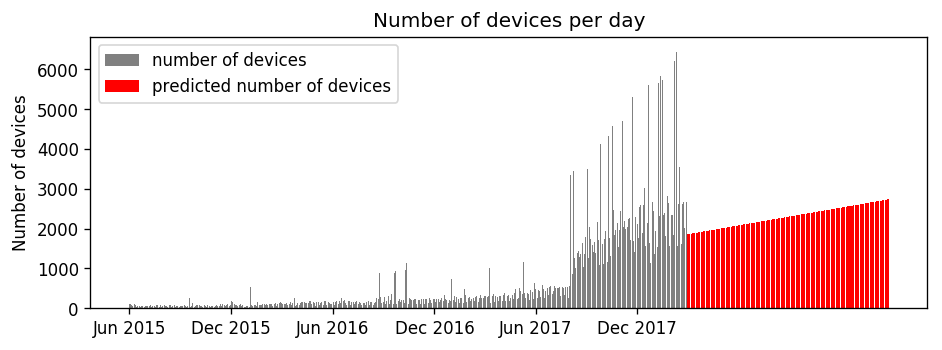

In [18]:
"""
draw number of devices bar plot
"""
# parameters
ticks_divider = 6  # x label tick every N months
graph_width = 9
graph_height = 3
graph_dpi = 120



# data x
x = []
for ndx, day in enumerate(all_days_list):
        x.append(ndx)
        
# predicted data x
x_predicted = []
for ndx in range(number_of_predicted_days):
        x_predicted.append(ndx + len(all_days_list))
    
# X label ticks    
# first and last date
first_day = events.loc[0]['date']
last_day = first_day + datetime.timedelta(days=len(all_days_list))
# generate list of months for x label
start_month_days = pandas.date_range(first_day, last_day, freq='MS')
x_label_ticks = start_month_days.strftime('%b %Y').tolist()
# calculate ticks locations
x_ticks_locations = []
for day in start_month_days:
    delta = day-first_day
    x_ticks_locations.append(delta.days)

# plot configuration

pyplot.figure(num=None, figsize=(graph_width,graph_height), dpi=graph_dpi)
pyplot.xticks(x_ticks_locations[0::ticks_divider], x_label_ticks[0::ticks_divider])
pyplot.ylabel('Number of devices')
pyplot.title('Number of devices per day')

# bar plots
plot1 = pyplot.bar(x, all_days_list, color='grey', label = 'number of devices')
plot1 = pyplot.bar(x_predicted, predicted_num_of_devices, color='red', label = 'predicted number of devices')

pyplot.legend()
pyplot.show()
    


In [91]:
"""
Task 2b
Users to contact
"""

users_devices = calculate_users_devices(one_day_events)


for user in users_devices:
    print('user: {},   number of devices: {}'.format(user,users_devices[user]))

'\nTask 2b\nUsers to contact\n'

In [183]:
def add_to_common_df(row, users_devices):
    if row['user_id'] in users_devices.index:
        users_devices.loc[row['user_id']]['devices'].append(row['device_id'])
    else:
        users_devices.loc[row['user_id']] = [[row['device_id']]]
        

In [184]:
"""
Task 2b
Users to contact
"""

X = 3

# events date to datetype
events['date'] = pandas.to_datetime(events['date'])
# create column with date only
events['date_only'] = events['date'].dt.date
# get first day
current_day = events.loc[0]['date_only']

users_devices = pandas.DataFrame()
# users_devices['user_id'] = []
users_devices['devices'] = [[]]
# iterate through all days
print(users_devices)
for day in range(X):
    # get current day end
    next_day = current_day + datetime.timedelta(days=1)
    # create one day mask - set True to events that are in selected timeframe
    one_day_mask = (events['date_only'] >= current_day) & (events['date_only'] < next_day)
    # select first day
    one_day_events = events.loc[one_day_mask]
    # users devices
    one_day_first_connections = only_first_con_events(one_day_events)
    one_day_first_connections.apply(add_to_common_df, 'columns', users_devices = users_devices)
    current_day = next_day


  devices
0      []
                   date  device_id  user_id  server_id  connection_state  \
0   2015-05-31 14:30:00        101        1          2              True   
1   2015-05-31 14:30:00        102        1          2              True   
2   2015-05-31 14:30:00        103       26          2              True   
3   2015-05-31 14:30:00        104        1          2              True   
4   2015-05-31 14:30:00        105        1          2              True   
5   2015-05-31 14:30:00        106        1          2              True   
6   2015-05-31 14:30:00         10        6          2              True   
7   2015-05-31 14:30:00        107        1          2              True   
8   2015-05-31 14:30:00        108       27          2              True   
9   2015-05-31 14:30:00        109        1          2              True   
10  2015-05-31 14:30:00        110        1          2              True   
11  2015-05-31 14:30:00         11        1          2              

date                2015-05-31 14:30:00
device_id                            83
user_id                              21
server_id                             2
connection_state                   True
date_only                    2015-05-31
Name: 229, dtype: object
date                2015-05-31 14:30:00
device_id                            85
user_id                              22
server_id                             2
connection_state                   True
date_only                    2015-05-31
Name: 231, dtype: object
date                2015-05-31 14:30:00
device_id                            86
user_id                              23
server_id                             2
connection_state                   True
date_only                    2015-05-31
Name: 232, dtype: object
date                2015-05-31 14:30:00
device_id                            90
user_id                              24
server_id                             2
connection_state                   True
date_

                    date  device_id  user_id  server_id  connection_state  \
725  2015-06-02 00:30:00        226        4          2              True   
726  2015-06-02 00:30:00        228        4          2             False   
727  2015-06-02 00:30:00        243        4          2              True   
728  2015-06-02 00:30:00        249        5          2             False   
729  2015-06-02 00:30:00        250        5          2              True   
730  2015-06-02 00:30:00        253       54          2             False   
731  2015-06-02 00:30:00        254        4          2              True   
732  2015-06-02 00:30:00        255        5          2              True   
733  2015-06-02 00:30:00        258        4          2              True   
734  2015-06-02 00:30:00        263        4          2              True   
735  2015-06-02 00:30:00        273       59          2              True   
736  2015-06-02 00:30:00        276        4          2              True   

In [157]:
x = [3]
x + [1]

[3, 1]